# **Projekt: Fehlererkennung in Getrieben**
## Netztyp 2: FFT-Net

#### **Vorbereitung**

In [1]:
# import libraries
import numpy as np
import os
from pandas import DataFrame, concat
from pathlib import Path

# module imports from /src
if Path.cwd().stem == "notebooks":
    os.chdir( Path.cwd().parent)

import src.data_loader_v2 as dl
import src.visualization as vis
import src.model_constructor as mc

In [2]:
# set the source directory for the preprocessed data to use
SOURCE: str = "d25dcf77-8463-4151-9135-bc014da98d7c"

# setup a single index for control purposes
CONTROL_INDEX: int = 1

In [3]:
# setup system and check the number of cpu cores and gpus available
mc.system_setup()

Number of CPU cores:		12
Number of GPUs available:	0


#### **Laden der Datensätze**

In [4]:
# load data from folder and split in training and evaluation data
data_path = Path().cwd() / "data" / "processed" / SOURCE
development_data, evaluation_data = dl.load_all_datasets(data_path)

READING TRAINING DATA
0D.csv successfully loaded.
1D.csv successfully loaded.
2D.csv successfully loaded.
3D.csv successfully loaded.
4D.csv successfully loaded.
READING EVALUATION DATA
0E.csv successfully loaded.
1E.csv successfully loaded.
2E.csv successfully loaded.
3E.csv successfully loaded.
4E.csv successfully loaded.
READING COMPLETED


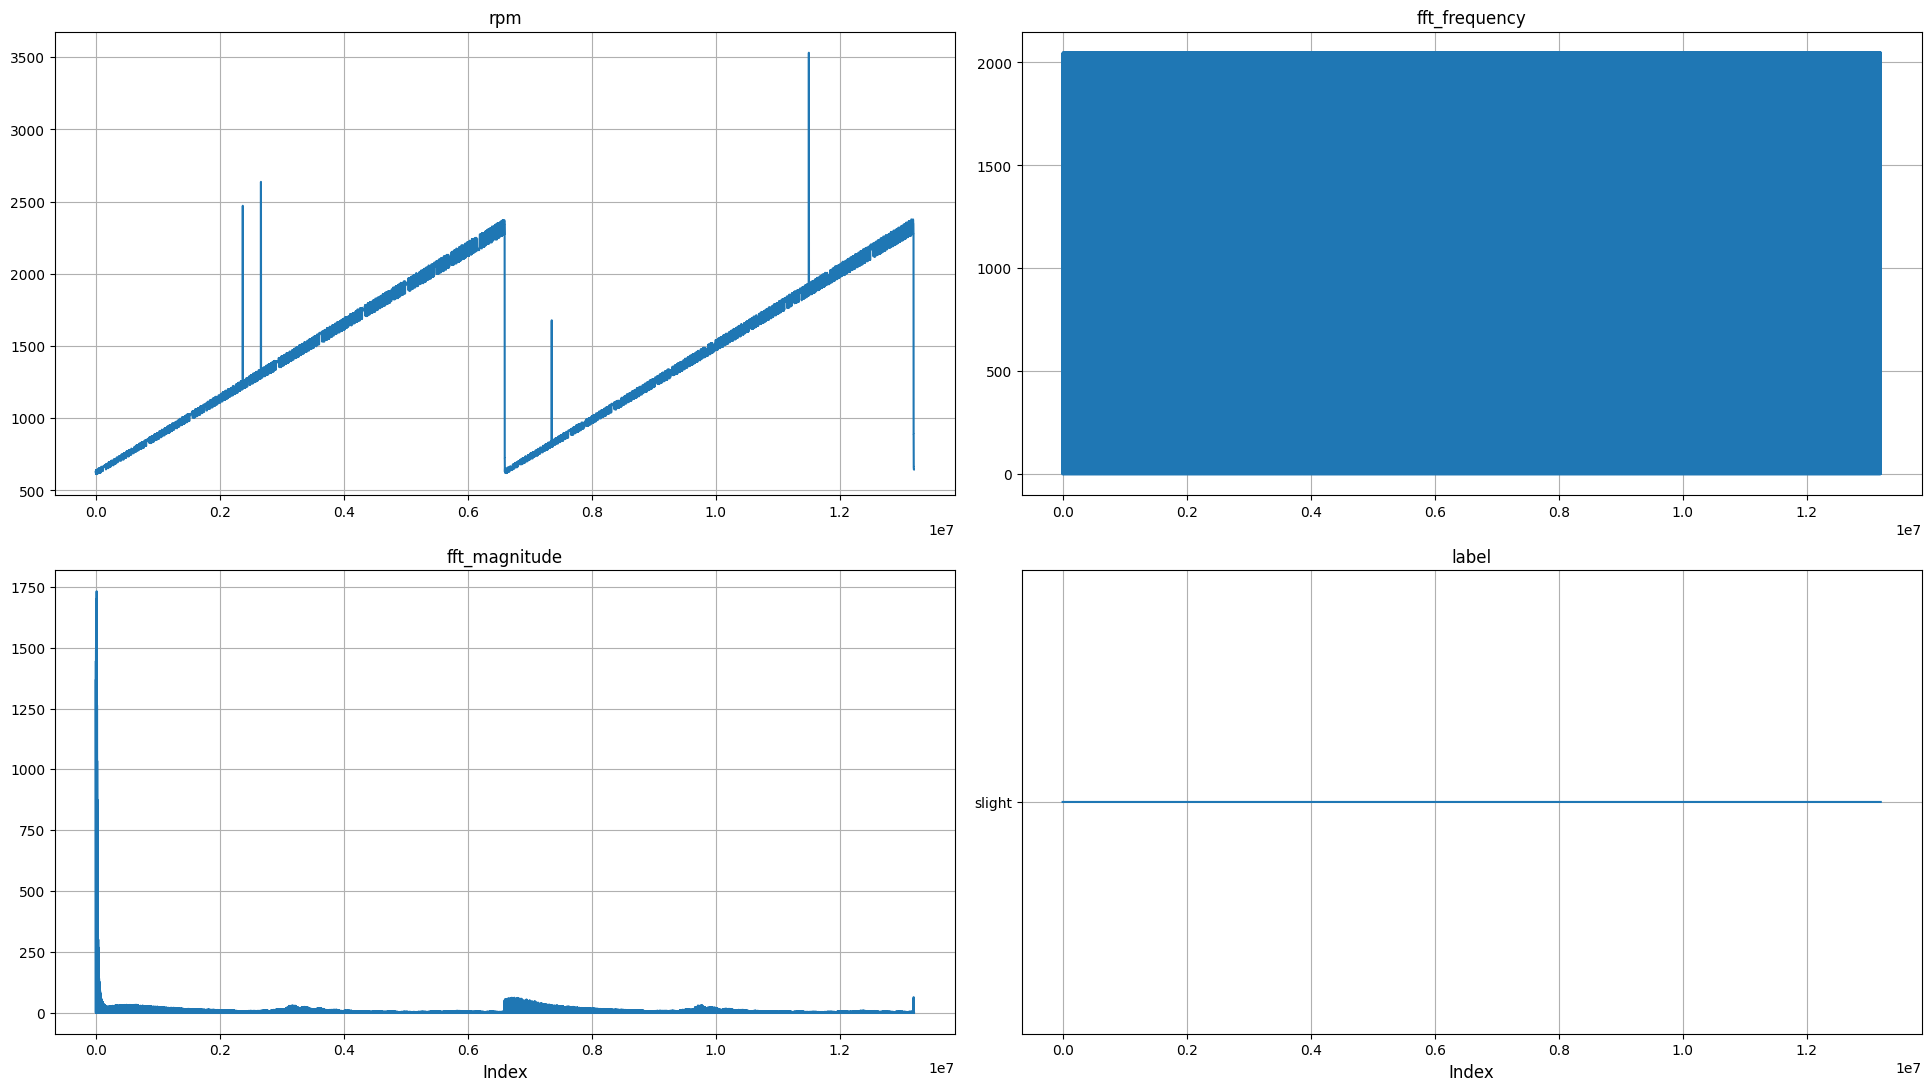

In [6]:
# visualize one random dataset for data validation
vis.plot_columns_as_subplots(development_data[CONTROL_INDEX],
                             development_data[CONTROL_INDEX].columns)

#### **Das Neuronale Netz**



In [23]:
LEARNING_RATE: float = 1e-3
BATCH_SIZE: int = 32
EPOCHS: int = 10
N_HIDDEN_LAYERS: int = 4

In [33]:
from sklearn.preprocessing import LabelEncoder
import keras
from keras.utils import to_categorical
from keras import layers
from pandas import concat
import tensorflow as tf
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.callbacks import EarlyStopping

def merge_dataframes(dataframes: list[DataFrame]):
    keys = []
    for dataset in dataframes:
        keys.append(dataset.attrs["path"].stem)

    return concat(dataframes, keys=keys)


def split_fft_training_data(dataframe: DataFrame, mode: str = "kfold", train_size: int = 0.1, n_folds: int = 10):
    options = ["simple", "kfold"]
    if mode not in options:
        raise AttributeError(f"Invalid mode selected! Please select on of the following:\t{options}")
    
    
    samples = dataframe["fft_magnitude"].to_numpy()
    labels = dataframe["label"].to_numpy()

   

    # reshape dataframe data to window sized samples
    samples = np.reshape(samples, (-1, 2048))
    labels = np.reshape(labels, (-1, 2048))

    # reduce to single label per 2048 samples
    labels = labels[:,0]
    n_classes =  len(np.unique(labels))

    # one hot encoding
    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)
    labels = to_categorical(labels, num_classes=n_classes)

    training_data = []
    validation_data = []

    match mode:
        case "simple":
            x_training, x_validation, y_training, y_validation = train_test_split(samples, labels, train_size=train_size,shuffle=False, random_state=None)
            training_set = tf.data.Dataset.from_tensor_slices(tensors=(x_training, y_training), name="training_set")
            validation_set = tf.data.Dataset.from_tensor_slices(tensors=(x_validation, y_validation), name="validation_set")
            
            # full shuffle of the datasets
            training_set = training_set.shuffle(buffer_size=training_set.cardinality(),
                                                    seed=None,
                                                    reshuffle_each_iteration=False)
                
            validation_set = validation_set.shuffle(buffer_size=validation_set.cardinality(),
                                                    seed=None,
                                                    reshuffle_each_iteration=False)
            
            training_data.append(training_set)
            validation_data.append(validation_set)

        case "kfold":

            kf = KFold(n_splits=n_folds, shuffle=False)

            for fold_index, (training_indices, validation_indices) in enumerate(kf.split(samples)):
                x_training, x_validation = samples[training_indices], samples[validation_indices]
                y_training, y_validation = labels[training_indices], labels[validation_indices]

                training_set = tf.data.Dataset.from_tensor_slices(tensors=(x_training, y_training),
                                                                   name=f"training_set_{fold_index}")#.batch(None)#.prefetch(tf.data.AUTOTUNE)
                validation_set = tf.data.Dataset.from_tensor_slices(tensors=(x_validation, y_validation),
                                                                     name=f"validation_set_{fold_index}")#.batch(None)#.prefetch(tf.data.AUTOTUNE)
                
                training_set = training_set.shuffle(buffer_size=training_set.cardinality(),
                                                    seed=None,
                                                    reshuffle_each_iteration=False)
                
                validation_set = validation_set.shuffle(buffer_size=validation_set.cardinality(),
                                                    seed=None,
                                                    reshuffle_each_iteration=False)


                training_data.append(training_set)
                validation_data.append(validation_set)


                # Ausgabe für diesen Fold
                print(f"Fold {fold_index}:")
                print(f"  Training samples: {len(x_training)}")
                print(f"  Validation samples: {len(x_validation)}")
    
    return training_data, validation_data

def create_fft_model(input_shape: tuple[int, ], output_shape: tuple[int, ], n_hidden_layers: int):
    model = keras.Sequential()
    model.add(keras.Input(shape=input_shape))
    model.add(layers.Dense(2048))

    # add the number of hidden layers
    for _ in range(n_hidden_layers):
        model.add(layers.Dense(1024))
        model.add(layers.LeakyReLU(negative_slope=0.3))
        
    model.add(layers.Dense(output_shape[0], activation="sigmoid"))

    model.summary()

    return model


def compile_fit_model(training_data: list[tf.data.Dataset], validation_data: list[tf.data.Dataset], epochs: int, batch_size: int, learning_rate: float, n_hidden_layers: int):

    for training_set, validation_set in zip(training_data, validation_data):
        training_sample_spec, training_label_spec = training_set.element_spec

        input_shape = training_sample_spec.shape
        output_shape = training_label_spec.shape

        print(input_shape)
        print(output_shape)

        training_set = training_set.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)
        validation_set = validation_set.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

        model = create_fft_model(input_shape=input_shape, output_shape=output_shape, n_hidden_layers=n_hidden_layers)


        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=keras.losses.CategoricalCrossentropy(),
            metrics=[
                keras.metrics.CategoricalAccuracy(),
                keras.metrics.FalseNegatives(),
            ],
        )

        # Early Stopping Callback
        early_stop = EarlyStopping(monitor='val_loss', patience=10)

        model.fit(training_set, validation_data=validation_set, epochs=epochs, batch_size=batch_size, callbacks=[early_stop])


        # validation_sample_spec, validation_label_spec = validation_set.element_spec
        
        break



merged_data = merge_dataframes(development_data)

training_data, validation_data = split_fft_training_data(merged_data)

compile_fit_model(training_data=training_data, validation_data=validation_data, epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, n_hidden_layers=N_HIDDEN_LAYERS)

Fold 0:
  Training samples: 28989
  Validation samples: 3222
Fold 1:
  Training samples: 28990
  Validation samples: 3221
Fold 2:
  Training samples: 28990
  Validation samples: 3221
Fold 3:
  Training samples: 28990
  Validation samples: 3221
Fold 4:
  Training samples: 28990
  Validation samples: 3221
Fold 5:
  Training samples: 28990
  Validation samples: 3221
Fold 6:
  Training samples: 28990
  Validation samples: 3221
Fold 7:
  Training samples: 28990
  Validation samples: 3221
Fold 8:
  Training samples: 28990
  Validation samples: 3221
Fold 9:
  Training samples: 28990
  Validation samples: 3221
(2048,)
(5,)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,448,453 (36.04 MB)

 Trainable params: 9,448,453 (36.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
906/906 ━━━━━━━━━━━━━━━━━━━━ 56s 59ms/step - categorical_accuracy: 0.6937 - false_negatives_5: 702.1047 - loss: 7.4675 - val_categorical_accuracy: 0.9131 - val_false_negatives_5: 171.0000 - val_loss: 21.0736
Epoch 2/10
906/906 ━━━━━━━━━━━━━━━━━━━━ 53s 58ms/step - categorical_accuracy: 0.4756 - false_negatives_5: 23.8258 - loss: 0.5712 - val_categorical_accuracy: 0.9749 - val_false_negatives_5: 24.0000 - val_loss: 6.4056
Epoch 3/10
906/906 ━━━━━━━━━━━━━━━━━━━━ 53s 58ms/step - categorical_accuracy: 0.6323 - false_negatives_5: 19.6395 - loss: 0.3940 - val_categorical_accuracy: 0.9410 - val_false_negatives_5: 13.0000 - val_loss: 1.5776
Epoch 4/10
906/906 ━━━━━━━━━━━━━━━━━━━━ 52s 57ms/step - categorical_accuracy: 0.7288 - false_negatives_5: 5.8247 - loss: 0.0520 - val_categorical_accuracy: 0.9491 - val_false_negatives_5: 42.0000 - val_loss: 5.0552
Epoch 5/10
906/906 ━━━━━━━━━━━━━━━━━━━━ 52s 57ms/step - categorical_accuracy: 0.6953 - false_negatives_5: 11.7795 - loss: 0.0893 - val

In [18]:
LEARNING_RATE: float = 1e-3
BATCH_SIZE: int = 32
EPOCHS: int = 100

SHUFFLE
MULTIPLE SENSORS
HEATMAP -> ANZAHL NEURONEN, HIDDEN LAYER, LOSS

In [ ]:

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
    ],
)

model.fit(training_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE)

ValueError: Argument `validation_split` is only supported for tensors or NumPy arrays.Found incompatible type in the input: [<class 'tensorflow.python.data.ops.shuffle_op._ShuffleDataset'>]

In [10]:
predictions = model.predict(training_samples)
predicted_classes = np.argmax(predictions, axis=1)
predicted_label = encoder.inverse_transform(predicted_classes)
print(predicted_label)

1007/1007 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
['moderat' 'moderat' 'moderat' ... 'moderat' 'moderat' 'significant']
